In [1]:
import pandas as pd
import re
import time
import binascii
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
small_dataset = 'data/news_articles_small.csv'
df_small_dataset = pd.read_csv(small_dataset)

In [3]:
"""
    Pre-process data:
        1. convert all to lowercase
        2. remove punctuation
"""

#Convert to lowercase.
df_small_dataset['article'] = df_small_dataset['article'].str.lower()

#Remove punctuation
p = re.compile(r'[^\w\s]+')
df_small_dataset['article'] = [p.sub('', x) for x in df_small_dataset['article'].tolist()]

In [4]:
"""
    Split each document in a list of words

    small_dataset_split = [
        [documentID, document_text]
    ]
"""

small_dataset_split = []
for idx, row in df_small_dataset.iterrows():
    small_dataset_split.append([row[0], row[1].split()])

In [5]:
"""
    createShingles

    To create the shingles for the articles in the dataframe
    @:param small_dataset_split - The dataframe with the articles
"""

def createShingles(small_dataset_split):
#Add shingles with ngram 4
#Source: https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py
    shingledDocs = {}
    docIds = []

    t0 = time.time()

    totalShingles = 0
    for docId, article in small_dataset_split:
        shingles = set()
        for i in range(0, len(article) - 3):
            shingle = article[i]+ " " + article[i + 1] + " " + article[i + 2] + " " + article[i + 3]

            crc =  binascii.crc32(shingle.encode()) & 0xffffffff
            shingles.add(crc)

        shingledDocs[docId]= shingles
        docIds.append(docId)
        totalShingles = totalShingles + (len(article) - 3)

    t1 = time.time()
    print('Time spent: ', t1-t0)
    return shingledDocs, docIds, totalShingles

In [6]:
"""
    randomHash

    To create random hash functions
    @:param value
    @:param rand_value
"""
def randomHash(value, rand_value):
    return binascii.crc32(value.to_bytes(32, "little")) ^ rand_value

"""
    randomList

    To create random hash functions
    @:param value
    @:param seed
"""
def randomList(n, seed=10):
    random.seed(10)
    l = []
    for i in range(n):
        r = random.getrandbits(32)
        l.append(r)
    return l


In [7]:
shingledDocs, docIds, totalShingles = createShingles(small_dataset_split)

Time spent:  0.3547780513763428


In [8]:
print("Generating random hash functions...")
# Number of hash functions
M = 1000
random_values = randomList(M)

Generating random hash functions...


In [9]:
"""
    MinHashing from shingles
"""
signatures = []
t0 = time.time()
for doc in docIds:
    signature = []
    for hash_fun in range(M):
        min_value = 0
        random_value = random_values[hash_fun]
        for shingle in shingledDocs[doc]:
            hash_value = randomHash(shingle, random_value)
            if hash_value < min_value or min_value == 0:
                min_value = hash_value
        
        signature.append(min_value)
    signatures.append(signature)

t1= time.time()

print('Time spent: ', t1-t0)

Time spent:  223.84391617774963


## Method 1


In [11]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

def calc_metrics(df):

    cm = confusion_matrix(df[['label_real']],df[['label_calc']])
    print('Confusion Matrix : \n', cm)

    total=sum(sum(cm))
    #####from confusion matrix calculate accuracy
    accuracy=(cm[0,0]+cm[1,1])/total
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    
    return accuracy, specificity, sensitivity, precision

In [10]:
def check_metrics(candidates, results, weights):
    sim = pd.DataFrame(list(candidates), columns=["doc1", "doc2"])
    sim['label'] = 1
    merged = real_sim.merge(sim, left_on=['doc1','doc2'], right_on=['doc1','doc2'], suffixes=['_real', '_calc'], how="left")
    merged = merged.fillna(0)
    metrics = calc_metrics(merged)
    mult = [a*b for a,b in zip(weights,metrics)]
    combined = float(sum(mult) / sum(weights))
    print(" Accuracy: ", metrics[0], "\n Specificity: ", metrics[1],
     "\n Sensitivity: ", metrics[2],"\n Precision: ", metrics[3], 
          "\n combined: ", combined)
    
    return metrics, combined

In [12]:
real_sim = pd.read_csv("real_sim.csv")
real_sim['label'] = np.where(real_sim['sim'] >= 0.8, 1, 0)
real_sim.head()

,Unnamed: 0,doc1,doc2,sim,label
0,0,0,1,0.058333,0
1,1,0,2,0.058333,0
2,2,0,3,0.067669,0
3,3,0,4,0.054852,0
4,4,0,5,0.072650,0


In [13]:
from numpy import long

"""
    LSH
"""
from itertools import combinations

LARGE_PRIME = 433494437

class LSH:
    def __init__(self, b, r):
        self.counter = 0
        self.b = b
        self.r = r
        self.hash_tables= {}

        self.create_hash_tables()
        # print(self.hash_tables)
        # for i in range(b):
        #     self.buckets.append({})

    def create_hash_tables(self):
        # The hash function must be (s1, s2, p1, p2) sensitive
        # We need to have r hash functions
        # Per band we have a hash table

        # Add hash tables
        for i in range(self.b):
            self.hash_tables[i] = {}

    def hash(self, i, subvec):
        acc = ""
        for value in subvec:
            acc += str(int(float(value)))
#         print(int(int(acc) * LARGE_PRIME))
        return int(int(acc) * LARGE_PRIME)

    def add_to_hash_table(self, i, subvec):
#         print(self.counter)
        if subvec not in self.hash_tables[i]:
            self.hash_tables[i][subvec] = []
            self.hash_tables[i][subvec].append(self.counter)
        else:
            self.hash_tables[i][subvec].append(self.counter)

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = self.r
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)

    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            #Hash every subvector using another hash function
            #and add it to a different hash table that corresponds
            #to that hash function
#             print(i, subvec)
            hashed_subvec = self.hash(i+1, subvec)
            self.add_to_hash_table(i, hashed_subvec)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for i in self.hash_tables:
            
            keys = self.hash_tables[i].keys()
#             print(keys)
            for bucket in keys:
                hits = self.hash_tables[i][bucket]
#                 print(hits)
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

C:\Users\Katerina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [271]:
# def parameters(tolerance, r, s2=0.8, p2=0.99):
#     s1 = round(s2 - tolerance, 2)
#     b = round(np.log(1-p2) / np.log(1-s2**r))
#     M = r * b
#     p1 = round(1 - (1 - s1 ** r) ** b, 2)
#     return (b,r), (s1,s2,p1,p2)

In [15]:
def parameters(s, r, p):
    b = round(np.log(1-p) / np.log(1-s**r))
    M = r * b
    return (b,r), (s,p)

In [29]:
rows = np.linspace(2,10,9)
# rows = [3,7]
# similarities = np.linspace(0.6,0.9,4)
# similarities = [0.7, 0.8]
# probabilities = np.linspace(0.8,0.95,4)
probabilities = [0.7, 0.8, 0.9, 0.95, 0.99]
similarities = np.linspace(0.4,0.6,3)
ops = []
for s in similarities:
    for r in rows:
        for p in probabilities:
            params, v = parameters(s, r, p)
            l = params[0] * params[1]
            if l <= len(signatures[0]) and l > 80:
                ops.append((params, v))
print(len(ops))

40


In [30]:
probabilities

[0.7, 0.8, 0.9, 0.95, 0.99]

In [31]:
for op in ops:
    print("params: ", op[0][0],op[0][1], " values: ", op[1])

params:  35 3.0  values:  (0.4, 0.9)
params:  45 3.0  values:  (0.4, 0.95)
params:  70 3.0  values:  (0.4, 0.99)
params:  46 4.0  values:  (0.4, 0.7)
params:  62 4.0  values:  (0.4, 0.8)
params:  89 4.0  values:  (0.4, 0.9)
params:  116 4.0  values:  (0.4, 0.95)
params:  178 4.0  values:  (0.4, 0.99)
params:  117 5.0  values:  (0.4, 0.7)
params:  156 5.0  values:  (0.4, 0.8)
params:  34 3.0  values:  (0.5, 0.99)
params:  25 4.0  values:  (0.5, 0.8)
params:  36 4.0  values:  (0.5, 0.9)
params:  46 4.0  values:  (0.5, 0.95)
params:  71 4.0  values:  (0.5, 0.99)
params:  38 5.0  values:  (0.5, 0.7)
params:  51 5.0  values:  (0.5, 0.8)
params:  73 5.0  values:  (0.5, 0.9)
params:  94 5.0  values:  (0.5, 0.95)
params:  145 5.0  values:  (0.5, 0.99)
params:  76 6.0  values:  (0.5, 0.7)
params:  102 6.0  values:  (0.5, 0.8)
params:  146 6.0  values:  (0.5, 0.9)
params:  22 4.0  values:  (0.6, 0.95)
params:  33 4.0  values:  (0.6, 0.99)
params:  20 5.0  values:  (0.6, 0.8)
params:  28 5.0  val

In [32]:
len(signatures)

1000

In [33]:
# best_comb = 0
# res = []
# accuracy, spec, sens, precision
weights = [0,0,2,2]
t0 = time.time()
for op in ops:
    b = int(op[0][0])
    r = int(op[0][1])
    lsh = LSH(b,r)
    l = b * r
    for signature in signatures:
        lsh.add_hash(signature[:l])

    candidate_pairs = lsh.check_candidates()
    print(f"Candidate pairs for n={l} b={b} and r={r} ", op[1])
    print(f"Number of candidate pairs are {len(candidate_pairs)}")
    metrics, comb = check_metrics(candidate_pairs, real_sim, weights)
    if comb > best_comb:
        best_comb = comb
    res.append([comb, b, r, l, op[1], metrics])
    print("="*100)
t1 = time.time()
print("time spent: ", t1-t0)
print("best_res: ", best_comb)

Candidate pairs for n=105 b=35 and r=3  (0.4, 0.9)
Number of candidate pairs are 112
Confusion Matrix : 
 [[499388     87]
 [     0     25]]
 Accuracy:  0.9998258258258258 
 Specificity:  0.9998258171079634 
 Sensitivity:  1.0 
 Precision:  0.22321428571428573 
 combined:  0.6116071428571429
Candidate pairs for n=135 b=45 and r=3  (0.4, 0.95)
Number of candidate pairs are 121
Confusion Matrix : 
 [[499379     96]
 [     0     25]]
 Accuracy:  0.9998078078078078 
 Specificity:  0.9998077981880975 
 Sensitivity:  1.0 
 Precision:  0.2066115702479339 
 combined:  0.6033057851239669
Candidate pairs for n=210 b=70 and r=3  (0.4, 0.99)
Number of candidate pairs are 161
Confusion Matrix : 
 [[499339    136]
 [     0     25]]
 Accuracy:  0.9997277277277278 
 Specificity:  0.9997277140998048 
 Sensitivity:  1.0 
 Precision:  0.15527950310559005 
 combined:  0.577639751552795
Candidate pairs for n=184 b=46 and r=4  (0.4, 0.7)
Number of candidate pairs are 79
Confusion Matrix : 
 [[499420     55]

Confusion Matrix : 
 [[499442     33]
 [     4     21]]
 Accuracy:  0.9999259259259259 
 Specificity:  0.9999339306271585 
 Sensitivity:  0.84 
 Precision:  0.3888888888888889 
 combined:  0.6144444444444445
Candidate pairs for n=876 b=146 and r=6  (0.5, 0.9)
Number of candidate pairs are 67
Confusion Matrix : 
 [[499429     46]
 [     4     21]]
 Accuracy:  0.9998998998998999 
 Specificity:  0.9999079032984634 
 Sensitivity:  0.84 
 Precision:  0.31343283582089554 
 combined:  0.5767164179104478
Candidate pairs for n=88 b=22 and r=4  (0.6, 0.95)
Number of candidate pairs are 58
Confusion Matrix : 
 [[499438     37]
 [     4     21]]
 Accuracy:  0.999917917917918 
 Specificity:  0.9999259222183292 
 Sensitivity:  0.84 
 Precision:  0.3620689655172414 
 combined:  0.6010344827586207
Candidate pairs for n=132 b=33 and r=4  (0.6, 0.99)
Number of candidate pairs are 72
Confusion Matrix : 
 [[499427     48]
 [     1     24]]
 Accuracy:  0.9999019019019019 
 Specificity:  0.9999038990940488 

In [316]:
# lsh.hash_tables

In [34]:
res

[[0.6010344827586207,
  22,
  4,
  88,
  (0.6, 0.95),
  (0.999917917917918, 0.9999259222183292, 0.84, 0.3620689655172414)],
 [0.6466666666666666,
  33,
  4,
  132,
  (0.6, 0.99),
  (0.9999019019019019, 0.9999038990940488, 0.96, 0.3333333333333333)],
 [0.6760975609756097,
  20,
  5,
  100,
  (0.6, 0.8),
  (0.999951951951952, 0.9999599579558537, 0.84, 0.5121951219512195)],
 [0.6844444444444444,
  28,
  5,
  140,
  (0.6, 0.9),
  (0.999947947947948, 0.9999539516492317, 0.88, 0.4888888888888889)],
 [0.6995833333333333,
  37,
  5,
  185,
  (0.6, 0.95),
  (0.999945945945946, 0.999949947444817, 0.92, 0.4791666666666667)],
 [0.6767213114754098,
  57,
  5,
  285,
  (0.6, 0.99),
  (0.9999239239239239, 0.9999259222183292, 0.96, 0.39344262295081966)],
 [0.6435714285714286,
  25,
  6,
  150,
  (0.6, 0.7),
  (0.999961961961962, 0.9999779768757195, 0.68, 0.6071428571428571)],
 [0.64125,
  34,
  6,
  204,
  (0.6, 0.8),
  (0.9999579579579579, 0.9999719705690976, 0.72, 0.5625)],
 [0.5907692307692307,
  4

In [62]:
results = pd.DataFrame.from_records(res, columns=['combined', 'b', 'r', 'M', 'vals', 'metrics'])
results['similarity'], results['probability']=results.vals.str
results['acc'], results['spec'], results['sens'], results['prec']=results.metrics.str
results = results.drop(['vals', 'metrics'], axis=1)

In [64]:
results.head()

,combined,b,r,M,similarity,probability,acc,spec,sens,prec
0,0.601034,22,4,88,0.6,0.95,0.999918,0.999926,0.84,0.362069
1,0.646667,33,4,132,0.6,0.99,0.999902,0.999904,0.96,0.333333
2,0.676098,20,5,100,0.6,0.80,0.999952,0.999960,0.84,0.512195
3,0.684444,28,5,140,0.6,0.90,0.999948,0.999954,0.88,0.488889
4,0.699583,37,5,185,0.6,0.95,0.999946,0.999950,0.92,0.479167


In [65]:
results.to_csv("results.csv")

In [44]:
results[4][0]

(0.6, 0.95)

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(df['one'], df['two'], marker = 'o', c = df['key1'], alpha = 0.8)
ax.legend(*sc.legend_elements())
plt.show()

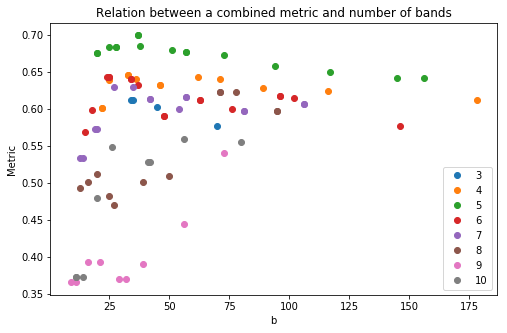

In [110]:
plt.figure(figsize=(8,5))
groups = results.groupby("r")
for name, group in groups:
    plt.plot(group["b"], group["combined"], marker="o", linestyle="", label=name)
plt.legend()
plt.xlabel('b')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and number of bands")
plt.show()

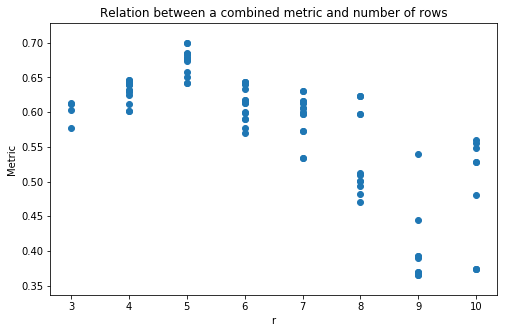

In [74]:
plt.figure(figsize=(8,5))
plt.scatter(results["r"],results["combined"])
# plt.legend()
plt.xlabel('r')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and number of rows")
plt.show()

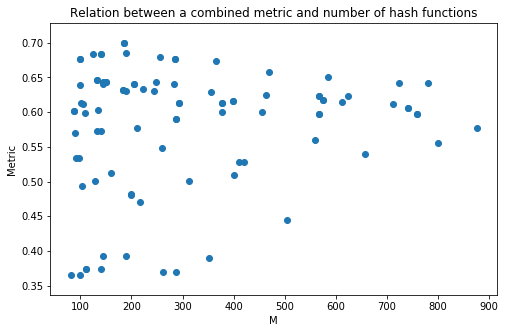

In [76]:
plt.figure(figsize=(8,5))
plt.scatter(results["M"],results["combined"])
plt.xlabel('M')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and number of hash functions")
plt.show()

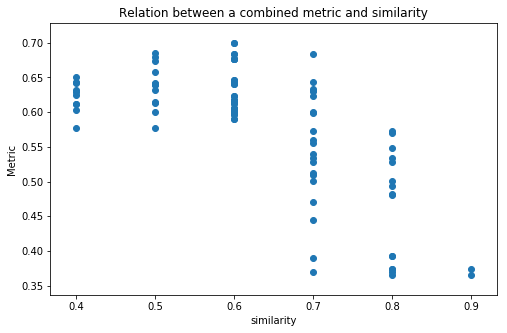

In [100]:
plt.figure(figsize=(8,5))
plt.scatter(results["similarity"],results["combined"])
plt.xlabel('similarity')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and similarity")
plt.show()

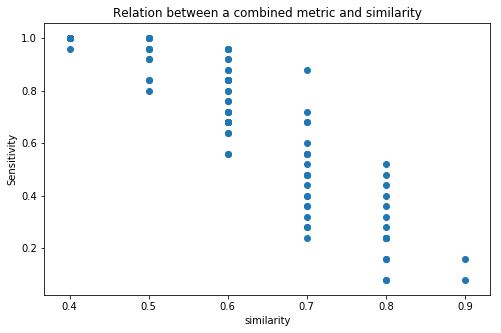

In [107]:
plt.figure(figsize=(8,5))
plt.scatter(results["similarity"],results["sens"])
plt.xlabel('similarity')
plt.ylabel('Sensitivity')
plt.title("Relation between a combined metric and similarity")
plt.show()

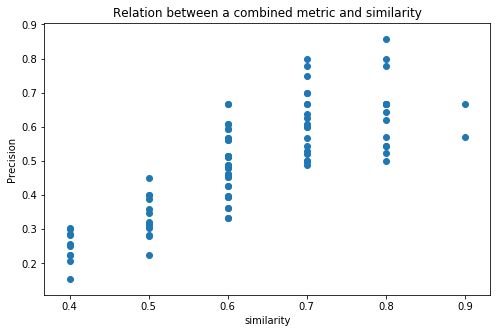

In [108]:
plt.figure(figsize=(8,5))
plt.scatter(results["similarity"],results["prec"])
plt.xlabel('similarity')
plt.ylabel('Precision')
plt.title("Relation between a combined metric and similarity")
plt.show()

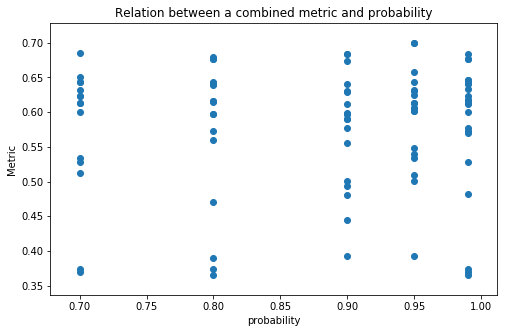

In [101]:
plt.figure(figsize=(8,5))
plt.scatter(results["probability"],results["combined"])
plt.xlabel('probability')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and probability")
plt.show()

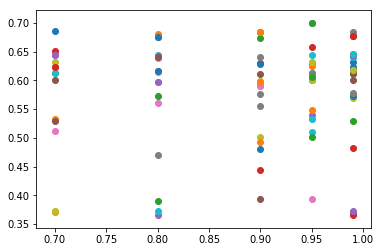

In [39]:
## different probability
for sim in res:
    plt.scatter(sim[4][1], sim[0])

## Method 2

In [ ]:
inverted_signs = []

for i in range(len(signatures[0])):
    invert = []
    for signature in signatures:
        invert.append(signature[0])
    inverted_signs.append(invert)


In [35]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

In [36]:
bs = [5, 10, 20, 25]
n = 100

matrix = np.array(inverted_signs)

for b in bs:
    r=n/b
    pairs = bandedCandidatePairs(matrix, b, r)
    print(f"Candidate pairs for n=100 b={b} and r={100/b}")
    print(f"Number of candidate pairs are {len(pairs)}")

Candidate pairs for n=100 b=5 and r=20.0
Number of candidate pairs are 88
Candidate pairs for n=100 b=10 and r=10.0
Number of candidate pairs are 88
Candidate pairs for n=100 b=20 and r=5.0
Number of candidate pairs are 88
Candidate pairs for n=100 b=25 and r=4.0
Number of candidate pairs are 88


In [37]:
matrix.shape


(100, 1000)